In this notebook we will build three different Encoder-Decoder models for translating french into English. <br>
The first model uses a LSTM layer as its encoder, and a LSTM layer as its decoder. The state of the encoder layer is passed to the decoder layer as context. <br>
The second model is similar to the first one, but we do not pass the encoder's state to the decoder and instead use an Attention layer. <br>
The third model is the same as the second one but we use 4 heads for the Attention layer instead of one. <br>
For each model we show translation example and compute the bleu score.

This notebook is mostly a rework of this one: https://www.tensorflow.org/text/tutorials/nmt_with_attention. 

# Data processing

For this notebook I used nltk instead of the Textprocessing layer of keras as an exercise.

In [2]:
import numpy as np 

import pandas as pd 

import matplotlib.pyplot as plt

import random

In [3]:
data = pd.read_csv('eng_-french.csv', nrows=None)

In [4]:
data = data.dropna()

In [5]:
data.columns = ['en', 'fr']

In [6]:
data.head()

,en,fr
0,Hi.,Salut!
1,Run!,Cours !
2,Run!,Courez !
3,Who?,Qui ?
4,Wow!,Ça alors !


In [9]:
# Display the first 5 rows
print("First 5 rows of the dataset:")
print(data.head())

# Display the last 5 rows
print("\nLast 5 rows of the dataset:")
print(data.tail())


First 5 rows of the dataset:
     en          fr
0   Hi.      Salut!
1  Run!     Cours !
2  Run!    Courez !
3  Who?       Qui ?
4  Wow!  Ça alors !

Last 5 rows of the dataset:
                                                       en  \
175616  Top-down economics never works, said Obama. "T...   
175617  A carbon footprint is the amount of carbon dio...   
175618  Death is something that we're often discourage...   
175619  Since there are usually multiple websites on a...   
175620  If someone who doesn't know your background sa...   

                                                       fr  
175616  « L'économie en partant du haut vers le bas, ç...  
175617  Une empreinte carbone est la somme de pollutio...  
175618  La mort est une chose qu'on nous décourage sou...  
175619  Puisqu'il y a de multiples sites web sur chaqu...  
175620  Si quelqu'un qui ne connaît pas vos antécédent...  


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175621 entries, 0 to 175620
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   en      175621 non-null  object
 1   fr      175621 non-null  object
dtypes: object(2)
memory usage: 2.7+ MB


As you can see the length of french and english texts varies, which means that a french sentence and its translation could have a different length. <br>
We can also see that a mojority of the texts have a length < to 100 words, so we will drop the ones with a superior one. 

In [7]:
from nltk import tokenize
import string
from unidecode import unidecode

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [8]:
data.map(lambda x: len(tokenize.sent_tokenize(x))).describe()

,en,fr
count,175621.000000,175621.000000
mean,1.009281,1.010039
std,0.098643,0.113824
min,1.000000,1.000000
25%,1.000000,1.000000
50%,1.000000,1.000000
75%,1.000000,1.000000
max,4.000000,5.000000


The vast majority of the dataset is only one sentence long.

In [9]:
data_fr = '\n'.join(data['fr'].tolist())
chars_fr = sorted(list(set(data_fr)))
chars_fr

['\n',
 ' ',
 '!',
 '"',
 '$',
 '%',
 '&',
 "'",
 '(',
 ')',
 '+',
 ',',
 '-',
 '.',
 '/',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ':',
 ';',
 '?',
 'A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 '\xa0',
 '«',
 '»',
 'À',
 'Â',
 'Ç',
 'É',
 'Ê',
 'Ô',
 'à',
 'á',
 'â',
 'ç',
 'è',
 'é',
 'ê',
 'ë',
 'î',
 'ï',
 'ô',
 'ö',
 'ù',
 'û',
 'œ',
 'С',
 '\u2009',
 '\u200b',
 '–',
 '‘',
 '’',
 '…',
 '\u202f',
 '‽',
 '₂']

In [10]:
data_en = '\n'.join(data['en'].tolist())
chars_en = sorted(list(set(data_en)))
chars_en

['\n',
 ' ',
 '!',
 '"',
 '$',
 '%',
 '&',
 "'",
 '+',
 ',',
 '-',
 '.',
 '/',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ':',
 ';',
 '?',
 'A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 '\xa0',
 '\xad',
 'º',
 'ç',
 'é',
 'ö',
 'ú',
 'а',
 '–',
 '—',
 '‘',
 '’',
 '₂',
 '€']

In the lists of characters for English and French sentences we can see that we need to clean some of them.

In [11]:
#Max features is the number of words, I did not set a limit for this notebook.
#The start, end, and unk token are important for the text processing and the fitting of the model.
max_features = None
start_token = '<START>'
end_token = '<END>'
unk_token = '<UNK>'
pad_token = '<PAD>'

In [12]:
def clean_text(texts, star_token=start_token, end_token=end_token):
    texts = texts.lower() #convert uppercase to lowercase
    texts = unidecode(texts, errors='ignore') #convert accented letters into unaccented letters. Ignore unknown characters.
    texts = ''.join((char if char in (string.punctuation + string.ascii_lowercase) else ' ' for char in texts)) #keep the selected letters and punctuation.
    
    return texts

In [13]:
data[['en_clean', 'fr_clean']] = data.map(clean_text)

Now we can look at the cleaned list of characters in the dataset.

In [14]:
data_en = '\n'.join(data['en_clean'].tolist())
chars_en = sorted(list(set(data_en)))
chars_en

['\n',
 ' ',
 '!',
 '"',
 '$',
 '%',
 '&',
 "'",
 '+',
 ',',
 '-',
 '.',
 '/',
 ':',
 ';',
 '?',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z']

In [15]:
data_fr = '\n'.join(data['fr_clean'].tolist())
chars_fr = sorted(list(set(data_fr)))
chars_fr

['\n',
 ' ',
 '!',
 '"',
 '$',
 '%',
 '&',
 "'",
 '(',
 ')',
 '+',
 ',',
 '-',
 '.',
 '/',
 ':',
 ';',
 '<',
 '>',
 '?',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z']

In [16]:
data

,en,fr,en_clean,fr_clean
0,Hi.,Salut!,hi.,salut!
1,Run!,Cours !,run!,cours !
2,Run!,Courez !,run!,courez !
3,Who?,Qui ?,who?,qui ?
4,Wow!,Ça alors !,wow!,ca alors !
...,...,...,...,...
175616,"Top-down economics never works, said Obama. ""T...","« L'économie en partant du haut vers le bas, ç...","top-down economics never works, said obama. ""t...","<< l'economie en partant du haut vers le bas, ..."
175617,A carbon footprint is the amount of carbon dio...,Une empreinte carbone est la somme de pollutio...,a carbon footprint is the amount of carbon dio...,une empreinte carbone est la somme de pollutio...
175618,Death is something that we're often discourage...,La mort est une chose qu'on nous décourage sou...,death is something that we're often discourage...,la mort est une chose qu'on nous decourage sou...
175619,Since there are usually multiple websites on a...,Puisqu'il y a de multiples sites web sur chaqu...,since there are usually multiple websites on a...,puisqu'il y a de multiples sites web sur chaqu...


In [17]:
sent_clean_fr = data['fr_clean'].tolist()
sent_clean_en = data['en_clean'].tolist()

We want to translate these sentences using a seq2seq model of tokenize words. So we need to tokenize the sentences of our dataset, build a dictionary from the tokenized words, and translate each sentences into a list of ids (each id corresponding to one word in the dictionary).

In [18]:
from collections import Counter

I built a class for Tokenizing the sentences. You need to, first, fit the class to your dataset using fit(), by doing this a dictionnary will be build using the "max_tokens" most commom words. Second, you need to call the tokenizer to create a dataset of sentences with words tokens and ids tokens. <br>
Also, we add start_token at the start of each tokenized sentences, and end_token at their end (if a word is not inside the dictionnary of words, the unk_token is added).

In [19]:
class Tokenize():
    def __init__(self, word_vocab=None, max_tokens=None, start_token='<START>', end_token='<END>', unk_token='<UNK>', pad_token='<PAD>'):
        self.max_tokens = max_tokens
        self.start_token = start_token
        self.end_token = end_token
        self.unk_token = unk_token
        self.pad_token = pad_token
        self.word_vocab = word_vocab
        if self.word_vocab:
            self.word_vocab = [self.pad_token, self.start_token, self.end_token, self.unk_token] + [word for word,count in word_count.most_common(max_tokens)]
            self.word_to_idx = {w:i for i,w in enumerate(self.word_vocab)}
            self.idx_to_word = {i:w for i,w in enumerate(self.word_vocab)}
            self.len_vocab = len(self.word_vocab)
    
    def fit(self, texts):
        
        if type(texts) == str: texts = [texts]
        
        word_count = Counter(tokenize.word_tokenize(' '.join(texts)))
        
        if self.max_tokens: 
            max_tokens = self.max_tokens -  3
        else:
            max_tokens = self.max_tokens
            
        self.word_vocab = [self.pad_token, self.start_token, self.end_token, self.unk_token] + [word for word,count in word_count.most_common(max_tokens)]
        self.word_to_idx = {w:i for i,w in enumerate(self.word_vocab)}
        self.idx_to_word = {i:w for i,w in enumerate(self.word_vocab)}
        self.len_vocab = len(self.word_vocab)
    
    def __call__(self, texts):
        if type(texts) == str: texts = [texts]
        texts_token = [[self.start_token] + tokenize.word_tokenize(text) + [self.end_token] for text in texts]
        texts_token_id = [[self.word_to_idx.get(word, self.word_to_idx[self.unk_token]) for word in sent] for sent in texts_token]
        
        return texts_token, texts_token_id
        

We split the dataset into train and validation sets. The tokenizers are fitted only on the train sets.

In [20]:
from sklearn.model_selection import train_test_split

sent_clean_fr_train,sent_clean_fr_valid,sent_clean_en_train,sent_clean_en_valid=train_test_split(sent_clean_fr,sent_clean_en,test_size=0.2,random_state=0)

The french tokenizer.

In [21]:
tokenize_fr = Tokenize()
tokenize_fr.fit(sent_clean_fr_train)
train_token_fr, train_id_fr = tokenize_fr(sent_clean_fr_train)
valid_token_fr, valid_id_fr = tokenize_fr(sent_clean_fr_valid)

The english tokenizer.

In [22]:
tokenize_en = Tokenize()
tokenize_en.fit(sent_clean_en_train)
train_token_en, train_id_en = tokenize_en(sent_clean_en_train)
valid_token_en, valid_id_en = tokenize_en(sent_clean_en_valid)

In [23]:
max_len_fr = max((len(text) for text in valid_token_fr))
max_len_fr

54

In [24]:
max_len_en = max((len(text) for text in valid_token_en))
max_len_en

48

The longest sequence is in french with 54 token, so we put a maximum length of 64 for our model.

In [25]:
max_len = 64

This function pad the sequences to the desired length. The pad token was defined previsously and set to have an id of 0. <br>
We are using teacher forcing for the english sequences therefore we need to shift the expected y values by one to the left. The model will take one word in the sequence and learn to predict the next word in the sequence until the end_token.

In [26]:
def make_dataset(query, value, max_length=50, return_shift=False, pad_token_id=0):
        if len(query) > max_length: 
            query_pad = query[:max_length]
        else:
            query_pad = query + [pad_token_id]*(max_length-len(query))
            
        if len(value) > max_length:
            value_pad = value[:max_length]
            value_shifted_pad = value[1:max_length+1]
        else:
            value_pad = value[:-1] + [pad_token_id]*(max_length-len(value[:-1]))
            value_shifted_pad = value[1:] + [pad_token_id]*(max_length-len(value[1:]))
            
        
        return query_pad, value_pad, value_shifted_pad

In [27]:
def shift(sent, pad_token_id=0):
    pad_token_shifted = sent[1:] + [pad_token_id] 
    return pad_token_shifted

In [28]:
query_pad_train, value_pad_train, value_shifted_pad_train = map(np.array,zip(*map(make_dataset, train_id_fr, train_id_en, [max_len]*len(train_id_en))))
query_pad_valid, value_pad_valid, value_shifted_pad_valid = map(np.array,zip(*map(make_dataset, valid_id_fr, valid_id_en, [max_len]*len(train_id_en))))

An example of what the shift does.

In [29]:
value_pad_train[0]

array([  1,  13,  11,  36, 316,   9,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0])

In [30]:
value_shifted_pad_train[0]

array([ 13,  11,  36, 316,   9,   2,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0])

In [31]:
fr_vocab = tokenize_fr.len_vocab
en_vocab = tokenize_en.len_vocab

The number of words in each dictionary.

In [32]:
print(fr_vocab, en_vocab)

25795 13292


# First Model (Decoder - Encoder)

In [33]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [34]:
UNITS = 1024
EPOCHS = 10
BATCH_SIZE = 256

In [35]:
from keras.layers import LSTM, Input, TimeDistributed, Dense, Activation, RepeatVector, Embedding, LayerNormalization, MultiHeadAttention, Add, Bidirectional, Concatenate

# Define an input sequence and process it.
encoder_inputs = Input(shape=(max_len))
x = Embedding(fr_vocab, UNITS)(encoder_inputs)
encoder_outputs, state_h, state_c = LSTM(UNITS, return_sequences=True, return_state=True, dropout=0.2)(x)
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(max_len))
decoder_embeddings = Embedding(en_vocab, UNITS)(decoder_inputs)

x = LSTM(UNITS, return_sequences=True, dropout=0.2)(decoder_embeddings, initial_state=encoder_states)

decoder_outputs = Dense(en_vocab)(x)

In [36]:
from keras.models import Model

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64)]                 0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 64)]                 0         []                            
                                                                                                  
 embedding (Embedding)       (None, 64, 1024)             2641408   ['input_1[0][0]']             
                                                          0                                       
                                                                                                  
 embedding_1 (Embedding)     (None, 64, 1024)             1361100   ['input_2[0][0]']         

The seqences are padded which means that most of the values are zeros. If we use the keras functions for loss and accuracy it will see the zeros as valid ids to generate, and give us very low loss and very good accuracy while basically generating only zeros. <br>
There two functions use a mask to only compute the accuracy and loss of the non padded sequences.

In [37]:
def masked_loss(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')
    loss = loss_fn(y_true, y_pred)

    # Mask off the losses on padding.
    mask = tf.cast(y_true != 0, loss.dtype)
    loss *= mask

    # Return the total.
    return tf.reduce_sum(loss)/tf.reduce_sum(mask)

def masked_acc(y_true, y_pred):
    # Calculate the accuracy for each item in the batch.
    y_pred = tf.argmax(y_pred, axis=-1)
    y_pred = tf.cast(y_pred, y_true.dtype)

    match = tf.cast(y_true == y_pred, tf.float32)
    mask = tf.cast(y_true != 0, tf.float32)

    return tf.reduce_sum(match)/tf.reduce_sum(mask)

In [38]:
# Compile & run training
model.compile(optimizer='adam', loss=masked_loss, metrics=[masked_acc, masked_loss])

In [39]:
history = model.fit([query_pad_train, value_pad_train], value_shifted_pad_train,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          validation_data=([query_pad_valid, value_pad_valid], value_shifted_pad_valid)
                   )

Epoch 1/10
549/549 [==============================] - 303s 544ms/step - loss: 4.0908 - masked_acc: 0.3285 - masked_loss: 4.0905 - val_loss: 3.3891 - val_masked_acc: 0.3917 - val_masked_loss: 3.3893
Epoch 2/10
549/549 [==============================] - 298s 544ms/step - loss: 2.9385 - masked_acc: 0.4626 - masked_loss: 2.9384 - val_loss: 2.5893 - val_masked_acc: 0.5276 - val_masked_loss: 2.5895
Epoch 3/10
549/549 [==============================] - 298s 543ms/step - loss: 2.2231 - masked_acc: 0.5761 - masked_loss: 2.2230 - val_loss: 2.1227 - val_masked_acc: 0.6046 - val_masked_loss: 2.1230
Epoch 4/10
549/549 [==============================] - 298s 543ms/step - loss: 1.7313 - masked_acc: 0.6506 - masked_loss: 1.7313 - val_loss: 1.8057 - val_masked_acc: 0.6562 - val_masked_loss: 1.8067
Epoch 5/10
549/549 [==============================] - 298s 543ms/step - loss: 1.3553 - masked_acc: 0.7113 - masked_loss: 1.3553 - val_loss: 1.5991 - val_masked_acc: 0.6932 - val_masked_loss: 1.5997
Epoch 6/10

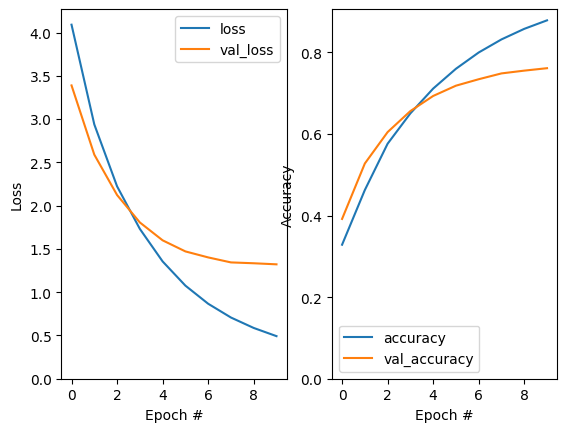

In [40]:
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['masked_acc'], label='accuracy')
plt.plot(history.history['val_masked_acc'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('Accuracy')
plt.legend()

In [41]:
def pad_seq(seq, max_length=50, pad_token_id=0):
        if len(seq) > max_length: 
            pad = seq[:max_length]
        else:
            pad = seq + [pad_token_id]*(max_length-len(seq))
            
        return pad

The model takes as input both french and english sentences, but of course if you want to translate a french sentence into an english one you can't do that. <br>
So what we are doing is we give the french sentence to our model and an array of zeros (except the first value which is equal to start_token). <br>
Then we use a while loop to generate one word after the other until the model generate an end_token or the maximum number of token that our model handles. <br>

In [42]:
def predict(text_fr, model=model, return_sent=False, pad_sent=False, print_gen=True):
    if pad_sent:
        sent_id_fr = text_fr
    else:
        clean_text_fr = clean_text(text_fr) #we clean the french sentence
        sent_token_fr, sent_id_fr = tokenize_fr(clean_text_fr) #convert the cleaned sentence into tokens of words and ids
        sent_id_fr = pad_seq(sent_id_fr[0], max_len) #we pad the sentence
    sent_id_en = np.zeros(max_len, dtype=np.int32) #the input english sentence is an array of 0 of max_len length 
    sent_id_en[0] = tokenize_en.word_to_idx[start_token] #we replace the first token by the start_token because that is how our model learned to map the data 
    predict = -1 
    seq_en = []
    i = 0
    while predict!=2 and i<max_len-1: # 2 is the id of end_token in our dictionary
        softmax = tf.keras.layers.Softmax() #the output of the models are logits so we need to use a softmax layer
        test_predict = softmax(model.predict([np.expand_dims(sent_id_fr, axis=0),  np.expand_dims(sent_id_en, axis=0)], verbose=False)) #we produce the sequences output
        predict = np.argmax(test_predict[0][i]) #we only care about the token predicted for the ith token and select the one with the most probability
        seq_en += [predict]
        sent_id_en[i+1] = predict
        i +=1
    if print_gen:
        print(' '.join([tokenize_en.idx_to_word[i] for i in seq_en if i!=2])) #we print the generated sentence without the end_token
    if return_sent:
        return sent_id_en

Some examples of translations.

In [43]:
#How are you?
sent_fr = "Comment vas-tu ?" 
predict(sent_fr, model=model)

how are you ?


In [44]:
#I'm fine.
sent_fr = "Je vais bien." 
predict(sent_fr, model=model)

i 'm okay .


In [45]:
#Tomorrow I will go buy some bread at backery, then I will go buy groceries.
sent_fr = "Demain j'irai acheter du pain à la boulangerie, puis j'irai faire les courses." 
predict(sent_fr, model=model)

if i go fishing or i 'll try to learn the toilet is better .


I know that nltk has its own BLEU integration but I wanted to do my own (it's not very good I know, I did it very quickly so I'm not very proud of it). <br>
I compute the BLEU score for each sequences in the valid dataset and do an average for each length but it takes too long so I simply select one random sequence per length and compute the score for each (hence why the plot is so uneven).

In [46]:
def make_ngrams(seq, n):
    n_grams = [tuple(seq[i:i+n]) for i in range(len(seq)-n+1)]
    n_counts = Counter(n_grams)
    return n_counts

In [47]:
def BLEU(generated_seq, target_seq, weight=[1/4,1/4,1/4,1/4]):
    g_seq = [c for c in generated_seq if c>0 and c!=2]
    t_seq = [c for c in target_seq if c>0 and c!=2]
    
    scores = []
    
    for i in range(4):
        n_counts_g = make_ngrams(g_seq, i+1)
        n_counts_t = make_ngrams(t_seq, i+1)
        
        score = sum((min(n_counts_t.get(gram, 0), n_counts_g[gram]) for gram in n_counts_g))       
        score /= sum(n_counts_g.values())
        
        scores += [score + 1e-1]
    
    if len(g_seq) > len(t_seq):
        BS = 1
    else:
        BS = np.exp(1- (len(t_seq)/len(g_seq)))

    BLEU = BS*np.exp(np.sum(weight*np.log(scores)))
    
    return BLEU

In [48]:
def generate_list(array, min_len, max_len):
    random_list = []
    len_list = []
    for length in range(max_len-min_len + 1):
        len_id = [i for i in range(len(array)) if (sum(array[i] != 0) - 2) == (length + min_len)]
        if len(len_id) > 0:
            random_list += [random.choice(len_id)] 
            len_list += [length + min_len]
    return random_list, len_list

In [49]:
max_len_valid = max((sum(query_pad_valid[i] != 0) - 2 for i in range(len(query_pad_valid))))
max_len_valid

52

In [50]:
random_list, len_list = generate_list(query_pad_valid, 4, max_len_valid)
random_list

[32129,
 27864,
 9249,
 3858,
 20951,
 34274,
 30779,
 6722,
 22763,
 24295,
 2079,
 2824,
 12070,
 30118,
 30394,
 34878,
 21629,
 34955,
 888,
 30088,
 19820,
 13632,
 28910,
 1085,
 23753,
 15349,
 31272,
 29200,
 18311,
 13107,
 19390,
 17217,
 8698,
 11088]

In [51]:
list_BLEU = [BLEU(predict(query_pad_valid[i], model=model, return_sent=True, pad_sent=True, print_gen=False), value_shifted_pad_valid[i]) for i in  random_list]

Text(0, 0.5, 'BLEU')

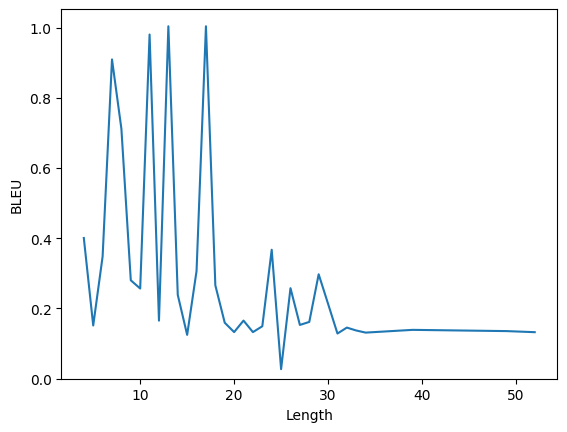

In [52]:
plt.plot(len_list, list_BLEU)
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Length')
plt.ylabel('BLEU')

# Second Model (Decoder - Encoder - Attention)

In [53]:
# Define an input sequence and process it.
encoder_inputs = Input(shape=(max_len))
x = Embedding(fr_vocab, UNITS)(encoder_inputs)
encoder_outputs = Bidirectional(merge_mode='sum', layer=LSTM(UNITS, return_sequences=True,
                           return_state=False, dropout=0.2))(x)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(max_len))
decoder_embeddings = Embedding(en_vocab, UNITS)(decoder_inputs)


x = LSTM(UNITS, return_sequences=True, dropout=0.2)(decoder_embeddings, initial_state=None)

#Attention 
attention = MultiHeadAttention(num_heads=1, key_dim=UNITS, dropout=0.2)
attention_output, attention_scores = attention(query=x, value=encoder_outputs, return_attention_scores=True)

add = Add()
normalization = LayerNormalization()

attention_seq = add([x, attention_output])
attention_seq = normalization(attention_seq)

decoder_outputs = Dense(en_vocab)(attention_seq)

In [54]:
# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model_A = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model_A.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 64)]                 0         []                            
                                                                                                  
 input_3 (InputLayer)        [(None, 64)]                 0         []                            
                                                                                                  
 embedding_3 (Embedding)     (None, 64, 1024)             1361100   ['input_4[0][0]']             
                                                          8                                       
                                                                                                  
 embedding_2 (Embedding)     (None, 64, 1024)             2641408   ['input_3[0][0]']       

In [55]:
model_A.compile(optimizer='adam', loss=masked_loss, metrics=[masked_acc, masked_loss])

In [56]:
history_A = model_A.fit([query_pad_train, value_pad_train], value_shifted_pad_train,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          validation_data=([query_pad_valid, value_pad_valid], value_shifted_pad_valid)
                   )

Epoch 1/10
549/549 [==============================] - 426s 765ms/step - loss: 3.1179 - masked_acc: 0.4745 - masked_loss: 3.1174 - val_loss: 1.5864 - val_masked_acc: 0.7013 - val_masked_loss: 1.5867
Epoch 2/10
549/549 [==============================] - 419s 763ms/step - loss: 1.2548 - masked_acc: 0.7417 - masked_loss: 1.2548 - val_loss: 1.0917 - val_masked_acc: 0.7801 - val_masked_loss: 1.0927
Epoch 3/10
549/549 [==============================] - 419s 764ms/step - loss: 0.7807 - masked_acc: 0.8146 - masked_loss: 0.7807 - val_loss: 0.9848 - val_masked_acc: 0.8046 - val_masked_loss: 0.9863
Epoch 4/10
549/549 [==============================] - 419s 764ms/step - loss: 0.5511 - masked_acc: 0.8581 - masked_loss: 0.5511 - val_loss: 0.9617 - val_masked_acc: 0.8149 - val_masked_loss: 0.9634
Epoch 5/10
549/549 [==============================] - 419s 764ms/step - loss: 0.4242 - masked_acc: 0.8858 - masked_loss: 0.4242 - val_loss: 0.9598 - val_masked_acc: 0.8219 - val_masked_loss: 0.9616
Epoch 6/10

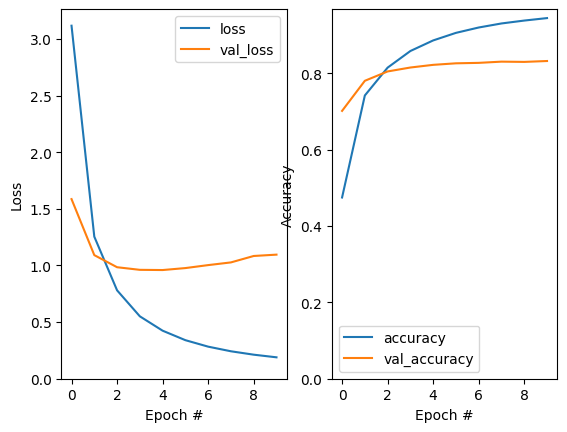

In [57]:
plt.subplot(1, 2, 1)
plt.plot(history_A.history['loss'], label='loss')
plt.plot(history_A.history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_A.history['masked_acc'], label='accuracy')
plt.plot(history_A.history['val_masked_acc'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('Accuracy')
plt.legend()

In [58]:
#How are you?
sent_fr = "Comment vas-tu ?" 
predict(sent_fr, model=model_A)

how are you ?


In [59]:
#I'm fine.
sent_fr = "Je vais bien." 
predict(sent_fr, model=model_A)

i 'm ok .


In [60]:
#Tomorrow I will go buy some bread at backery, then I will go buy groceries.
sent_fr = "Demain j'irai acheter du pain à la boulangerie, puis j'irai faire les courses." 
predict(sent_fr, model=model_A)

i 'll go to the bread and buy some of the bread , and then go to some sleep .


In [61]:
list_BLEU = [BLEU(predict(query_pad_valid[i], model=model_A, return_sent=True, pad_sent=True, print_gen=False), value_shifted_pad_valid[i]) for i in  random_list]

Text(0, 0.5, 'BLEU')

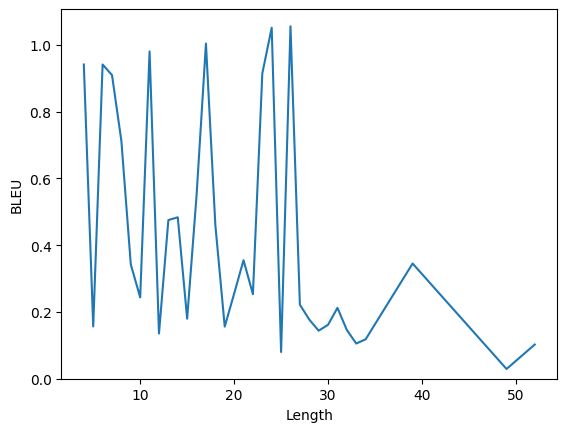

In [62]:
plt.plot(len_list, list_BLEU)
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Length')
plt.ylabel('BLEU')

# Third Model (Decoder - Encoder - Multi Headed Attention)

In [63]:
# Define an input sequence and process it.
encoder_inputs = Input(shape=(max_len))
x = Embedding(fr_vocab, UNITS)(encoder_inputs)
encoder_outputs = Bidirectional(merge_mode='sum', layer=LSTM(UNITS, return_sequences=True,
                           return_state=False, dropout=0.2))(x)



# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(max_len))
decoder_embeddings = Embedding(en_vocab, UNITS)(decoder_inputs)



x = LSTM(UNITS, return_sequences=True, dropout=0.2)(decoder_embeddings, initial_state=None)

#Attention 
attention = MultiHeadAttention(num_heads=4, key_dim=UNITS, dropout=0.2)
attention_output, attention_scores = attention(query=x, value=encoder_outputs, return_attention_scores=True)

add = Add()
normalization = LayerNormalization()

attention_seq = add([x, attention_output])
attention_seq = normalization(attention_seq)

decoder_outputs = Dense(en_vocab)(attention_seq)

In [64]:
# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model_MHA = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model_MHA.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 64)]                 0         []                            
                                                                                                  
 input_5 (InputLayer)        [(None, 64)]                 0         []                            
                                                                                                  
 embedding_5 (Embedding)     (None, 64, 1024)             1361100   ['input_6[0][0]']             
                                                          8                                       
                                                                                                  
 embedding_4 (Embedding)     (None, 64, 1024)             2641408   ['input_5[0][0]']       

In [65]:
model_MHA.compile(optimizer='adam', loss=masked_loss, metrics=[masked_acc, masked_loss])

In [66]:
history_MHA = model_MHA.fit([query_pad_train, value_pad_train], value_shifted_pad_train,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          validation_data=([query_pad_valid, value_pad_valid], value_shifted_pad_valid)
                   )

Epoch 1/10
549/549 [==============================] - 542s 977ms/step - loss: 4.1088 - masked_acc: 0.3328 - masked_loss: 4.1084 - val_loss: 2.9944 - val_masked_acc: 0.4824 - val_masked_loss: 2.9946
Epoch 2/10
549/549 [==============================] - 536s 976ms/step - loss: 2.2483 - masked_acc: 0.5973 - masked_loss: 2.2482 - val_loss: 1.6119 - val_masked_acc: 0.7071 - val_masked_loss: 1.6127
Epoch 3/10
549/549 [==============================] - 536s 976ms/step - loss: 1.3451 - masked_acc: 0.7379 - masked_loss: 1.3451 - val_loss: 1.2484 - val_masked_acc: 0.7673 - val_masked_loss: 1.2493
Epoch 4/10
549/549 [==============================] - 536s 976ms/step - loss: 0.9741 - masked_acc: 0.7924 - masked_loss: 0.9741 - val_loss: 1.1048 - val_masked_acc: 0.7911 - val_masked_loss: 1.1058
Epoch 5/10
549/549 [==============================] - 536s 976ms/step - loss: 0.7666 - masked_acc: 0.8250 - masked_loss: 0.7666 - val_loss: 1.0596 - val_masked_acc: 0.8055 - val_masked_loss: 1.0604
Epoch 6/10

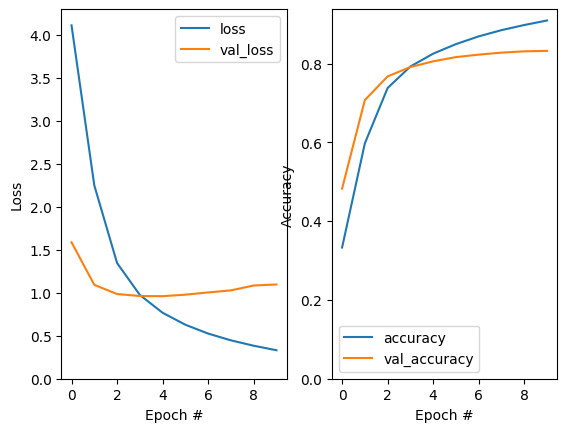

In [67]:
plt.subplot(1, 2, 1)
plt.plot(history_MHA.history['loss'], label='loss')
plt.plot(history_A.history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_MHA.history['masked_acc'], label='accuracy')
plt.plot(history_MHA.history['val_masked_acc'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('Accuracy')
plt.legend()

In [ ]:
#How are you?
sent_fr = "Comment vas-tu ?" 
predict(sent_fr, model=model_MHA)

how are you doing ?


In [ ]:
#I'm fine.
sent_fr = "Je vais bien." 
predict(sent_fr, model=model_MHA)

i 'm fine .


In [ ]:
#Tomorrow I will go buy some bread at backery, then I will go buy groceries.
sent_fr = "Demain j'irai acheter du pain à la boulangerie, puis j'irai faire les courses." 
predict(sent_fr, model=model_MHA)

i will go money at the bakery , then i 'll go shopping .


In [ ]:
list_BLEU = [BLEU(predict(query_pad_valid[i], model=model_MHA, return_sent=True, pad_sent=True, print_gen=False), value_shifted_pad_valid[i]) for i in  random_list]

Text(0, 0.5, 'BLEU')

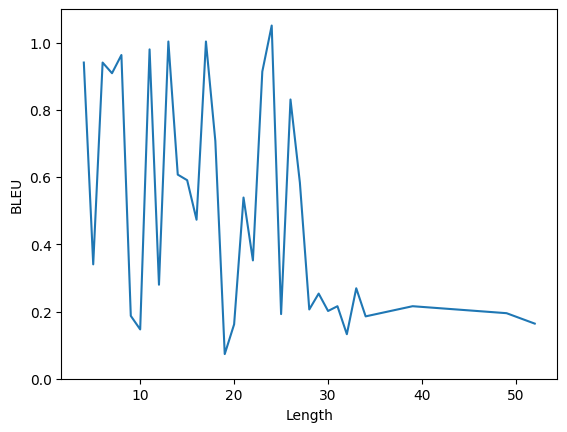

In [ ]:
plt.plot(len_list, list_BLEU)
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Length')
plt.ylabel('BLEU')